## A simple swarm

In [16]:
%load_ext autoreload 
%autoreload 2
import sys
sys.tracebacklimit = 0

import numpy as np
import networkx as nx 
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
from core.agent import *
from core.world import * 
from core.map import *
from core.render import * 
from core.env_params import * 
from core.skill import * 
from core.models import *
from core.env_params import *

In [18]:
def initialize_swarm(world : World):
    swarm = [Agent() for i in range(SWARM_SIZE)]
    skill_initializer = DefaultSkillInitializer(num_skills = PRODUCT_TYPES)
    utility_initializer = UtilitySampler()

    for agent in swarm:
        skill_initializer.forward(agent)
        utility_initializer.forward(agent)
        world.add_agent(agent)
    swarm = initialize_positions_randomly(world, swarm)
    

In [19]:
world = World(dims = WORLD_DIMS,
              swarm_initialzier= initialize_swarm,
              resource_generator= RandomMapGenerator(RESOURCE_TYPES, padding=MAX_VISIBILITY),
              energy_model=EnergyModel(),
              chemistry_model= ChemistryModel()
              )
world.reset()

In [20]:
# Test movements by doing random actions
def update():
    world.update()
    # Evaluate the agent's utility
    for agent in world.agents:
        agent.calculate_utility()

    # Comms protocol (receiving)
    for agent in world.agents: 
        received_messages = agent.get_messages()
        for msg in received_messages: 
            agent.add_relation(msg.sender, msg.message)
        agent.clear_messages()

    for agent in world.agents:
        action_choice = np.random.randint(0, 5)
        choice = np.random.randint(1, 5)

        match (action_choice): 
            case 1: agent.move(choice)
            case 2: agent.pick_up(choice)
            case 3: agent.put_down(choice)
            case 4: 
                prod_to_make = np.random.randint(RESOURCE_TYPES + 1, RESOURCE_TYPES + PRODUCT_TYPES + 1)
                agent.make(prod_to_make)
    
    # Comms protocol (sending )
    for agent in world.agents:
        neighbors = agent.agents_in_range 

        # Send agents
        if len (neighbors) > 0:
            choice = str(np.random.choice(neighbors))
            tgt_agent = world.get_agent(choice)
            agent.talk_to(tgt_agent)

update()

1 False


KeyError: 1

In [6]:
render_world(world, (800, 800), update_fn=update, delay_s=0)

# Data Visualization

## Social Network 

In [40]:
network = nx.graph.Graph()

for agent in world.agents:
    for neighbor in agent._current_state.relations:
        network.add_edge(agent.id, neighbor, weight = agent._current_state.relations[neighbor])

In [41]:
edges,weights = zip(*nx.get_edge_attributes(network ,'weight').items())
nx.draw_kamada_kawai(network, node_size = 10, edge_color = weights, edge_cmap = plt.cm.Spectral)

KeyboardInterrupt: 

## Economy

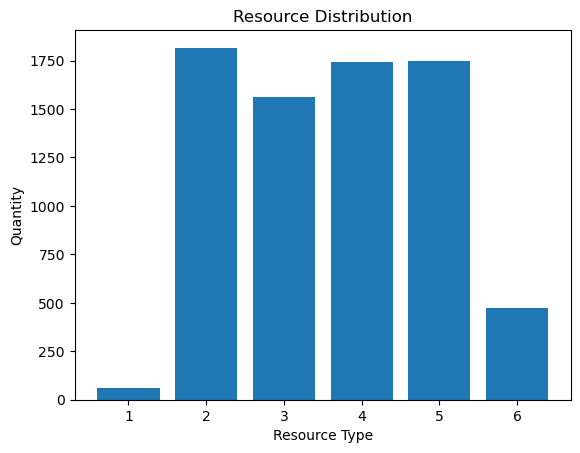

In [8]:
resources : dict[int, int]  = {}
for agent in world.agents: 
    inventory = agent._current_state.inventory
    for t, q in inventory.items():
        if not t in resources: 
            resources[t] = 0
        resources[t] += q

resource_types = list(resources.keys())
quantities = list(resources.values())

plt.bar(resource_types, quantities)
plt.xlabel('Resource Type')
plt.ylabel('Quantity')
plt.title('Resource Distribution')
plt.show()

## Utility

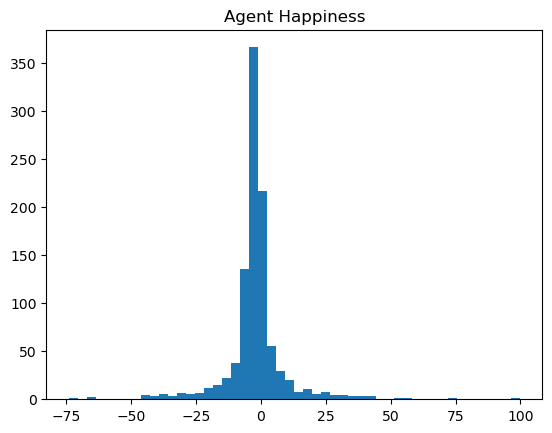

In [12]:
utilities = []
for agent in world.agents: 
    utilities.append(agent.utility)


plt.hist(utilities, 50)
plt.title('Agent Happiness')
plt.show()

# Verify certain things about the simulation

In [67]:
swarm = world.agents

In [11]:
# Validate the observation space provided is sensible
obs = swarm[123].local_observation

print(obs.nearby_agents, obs.nearby_agents.shape)
print(obs.resource_types, obs.resource_types.shape)

[[  0   0   0   0   0]
 [  0   0 201   0   0]
 [  0   0   0   0   0]
 [  0 124   0   0   0]
 [647   0   0   0   0]
 [  0   0   0   0   0]
 [  0   0   0   0   0]] (7, 5)
[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]] (7, 5)


In [68]:
# Validate that all observation spaces are square
for agent in swarm: 
    obs = agent.local_observation
    if (obs.resource_types.shape[0] != obs.resource_types.shape[1]):
        print(agent.current_position_const, obs.resource_types.shape)

In [12]:
# Validate that all swarm agents landed in different positions
positions = set()
for agent in swarm:
    pos = agent.current_position
    positions.add((pos[0], pos[1]))

print(len(positions), len(world.agents))

1000 1000


In [13]:
# Check for resources
rsrc_qty = world._resource_map._resource_quantity_map
qtys = []

for i in range(rsrc_qty.shape[0]):
    for j in range(rsrc_qty.shape[1]):
        if rsrc_qty[i, j] > 0:
            qtys.append(rsrc_qty[i, j])

print(qtys)

[4, 7, 6, 4, 7, 4, 3, 3, 2, 6, 3, 5, 4, 6, 4, 5, 4, 2, 3, 2, 3, 3, 6, 3, 5, 1, 3, 8, 2, 6, 3, 1, 1, 4, 6, 4, 6, 5, 3, 4, 6, 6, 4, 4, 2, 3, 6, 3, 4, 3, 5, 6, 5, 3, 1, 4, 1, 8, 8, 1, 3, 4, 5, 5, 7, 8, 2, 5, 6, 4, 4, 4, 5, 7, 2, 2, 6, 3, 5, 3, 2, 4, 3, 5, 9, 6, 7, 2, 4, 1, 7, 5, 1, 4, 1, 5, 1, 3, 4, 7, 1, 3, 5, 5, 2, 3, 7, 4, 3, 4, 7, 5, 6, 1, 5, 2, 1, 2, 5, 3, 2, 6, 4, 6, 4, 5, 6, 5, 2, 5, 7, 3, 4, 9, 4, 1, 2, 6, 6, 4, 4, 4, 8, 5, 4, 4, 4, 1, 5, 7, 3, 2, 2, 1, 5, 4, 2, 8, 5, 9, 5, 9, 3, 6, 5, 1, 3, 4, 3, 3, 5, 6, 2, 6, 4, 2, 5, 6, 1, 4, 4, 4, 6, 6, 5, 5, 2, 1, 1, 4, 9, 4, 2, 1, 3, 6, 5, 5, 5, 1, 1, 4, 3, 2, 1, 4, 3, 1, 4, 3, 4, 7, 2, 1, 3, 6, 2, 5, 3, 4, 4, 5, 5, 6, 2, 7, 1, 1, 1, 6, 1, 2, 4, 3, 1, 4, 1, 1, 7, 4, 3, 3, 3, 1, 6, 1, 6, 8, 5, 5, 3, 1, 7, 9, 1, 5, 2, 4, 1, 3, 3, 1, 3, 3, 2, 1, 1, 2, 6, 5, 1, 2, 5, 5, 5, 5, 2, 5, 3, 1, 6, 4, 2, 7, 4, 5, 5, 1, 5, 1, 4, 11, 6, 1, 2, 7, 6, 6, 3, 3, 3, 6, 2, 3, 1, 2, 2, 6, 4, 4, 5, 5, 6, 4, 1, 8, 5, 7, 2, 1, 1, 2, 4, 4, 2, 4, 5, 3, 6, 4, 6, 1, 4,

In [14]:
# Check for agent state
state = swarm[124]._current_state
print(state.inventory, state.current_utility)


{2: 2, 3: 2} -1.114025078450203


# Perftest

In [7]:
import cProfile
def stress_test():
    np.random.seed(42)
    world.reset()
    for _ in range(0, 1000):
        update()

In [8]:

cProfile.run('stress_test()', sort = 'time')

         68090883 function calls in 31.324 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
  2200089    2.813    0.000    2.813    0.000 {method 'randint' of 'numpy.random.mtrand.RandomState' objects}
  1000000    2.684    0.000    4.721    0.000 utility.py:17(forward)
     1000    1.984    0.002   31.401    0.031 1515484444.py:2(update)
   611006    1.604    0.000    3.957    0.000 {method 'choice' of 'numpy.random.mtrand.RandomState' objects}
  1000000    1.491    0.000    2.003    0.000 world.py:137(_get_nearby_agents)
     1000    1.371    0.001    2.175    0.002 world.py:92(_update_movement)
  1000000    1.281    0.000    3.110    0.000 observation.py:22(neighbors)
     1000    1.161    0.001   11.525    0.012 world.py:56(update)
  1000000    1.150    0.000    1.405    0.000 numeric.py:67(zeros_like)
  1000000    1.095    0.000    1.095    0.000 observation.py:28(<listcomp>)
   804345    0.984    0.000    0.984    0.00

In [ ]:
cProfile.run('world.update()', sort = 'time')